#### Consideraciones: 
- El dataset de ```poca_antelacion``` no puede incluir la columna ```lead_time``` en el modelo de Machine Learning, porque podríamos engañarlo, ya que de la manera que lo hemos creado todos los que tengan un ```lead_time``` mayor a 15 van a ser cancelaciones y no tiene porque ser así. 

#### Posibles modelos de clasificacion a utilizar:
- Utilizar la libreria Lazypredict

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
reservas = pd.read_csv("Data/hotel_bookings_clean.csv")
meteo_algarve = pd.read_csv("Data/meteo_algarve_clean.csv")
meteo_lisboa = pd.read_csv("Data/meteo_lisboa_clean.csv")
reservas['arrival_date'] = pd.to_datetime(reservas['arrival_date'])
reservas['reservation_status_date'] = pd.to_datetime(reservas['reservation_status_date'])
reservas['children'] = reservas['children'].astype(int)

In [3]:
mucha_antelacion = reservas[((reservas["is_canceled"] == 1) &
                             (reservas['arrival_date'] - reservas['reservation_status_date'] > pd.Timedelta(days=15)) |
                             ((reservas["is_canceled"] == 0) &
                              (reservas['lead_time'] > 15)))]
poca_antelacion = reservas[((reservas["is_canceled"] == 1) &
                            (reservas['arrival_date'] - reservas['reservation_status_date'] <= pd.Timedelta(days=15)) |
                            ((reservas["is_canceled"] == 0) &
                             (reservas['lead_time'] <= 15)))]
poca_antelacion.drop(columns='lead_time', inplace=True)

C:\Users\mrtfo\AppData\Local\Temp\ipykernel_27024\4046048785.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poca_antelacion.drop(columns='lead_time', inplace=True)


### Fechas expresadas en ángulos

Crearemos dos _features_ nuevas con los dias del año expresados en "Coordenadas Polares", en el que cada día está expresado por un ángulo entre $0$ y $360$ grados, aunque aquí lo expresaremos en radianes, de $0$ a $2\pi$. Una _feature_ será el coseno ($\cos$) del ángulo y la otra el seno ($\sin$). De esa forma habrá la misma distancia entre, por ejemplo, el 30 de enero y el 31 que entre el 31 de enero y el 1 de febrero. 

In [4]:
mucha_antelacion['arrival_date_year'] = mucha_antelacion['arrival_date'].dt.year
mucha_antelacion['arrival_date_day/month'] = mucha_antelacion['arrival_date'].dt.strftime('%d/%m')

C:\Users\mrtfo\AppData\Local\Temp\ipykernel_27024\3512363893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mucha_antelacion['arrival_date_year'] = mucha_antelacion['arrival_date'].dt.year
C:\Users\mrtfo\AppData\Local\Temp\ipykernel_27024\3512363893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mucha_antelacion['arrival_date_day/month'] = mucha_antelacion['arrival_date'].dt.strftime('%d/%m')


In [5]:
dias_por_mes_1 = [
    31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31
]
dias_por_mes_2 = [
    31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31
]

In [6]:
# Creamos una función que nos devuelva el numero de día del año, teniendo en cuenta el año bisiesto de nuestro período de 
# estudio, concretamente el año 2016. 

def dia_del_año(dia_mes, anio): 
    dia, mes = dia_mes.split('/')
    dia = int(dia)
    mes = int(mes)
    if anio%4 == 0: 
        return dia + sum(dias_por_mes_2[:mes-1])
    else:
        return dia + sum(dias_por_mes_1[:mes-1])

In [7]:
dias_mes = list(mucha_antelacion['arrival_date_day/month'])
anios = list(mucha_antelacion['arrival_date_year'])

In [8]:
# Pasamos el número de día a ángulo y calculamos seno y coseno. 

dias_x = []
dias_y = []
for dia, anio in zip(dias_mes,anios):
    if anio%4 == 0:
        angulo = 2*np.pi * dia_del_año(dia,anio)/366
        dias_x.append(np.cos(angulo))
        dias_y.append(np.sin(angulo))
    else:
        angulo = 2*np.pi * dia_del_año(dia,anio)/365
        dias_x.append(np.cos(angulo))
        dias_y.append(np.sin(angulo))

In [9]:
# Añadimos las nuevas columnas calculadas y quitamos las que hemos creado para calcularlas. 

mucha_antelacion['dia_x'] = dias_x
mucha_antelacion['dia_y'] = dias_y
mucha_antelacion.drop(columns=["arrival_date_day/month","arrival_date_year"],inplace=True) 

C:\Users\mrtfo\AppData\Local\Temp\ipykernel_27024\3388695010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mucha_antelacion['dia_x'] = dias_x
C:\Users\mrtfo\AppData\Local\Temp\ipykernel_27024\3388695010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mucha_antelacion['dia_y'] = dias_y
C:\Users\mrtfo\AppData\Local\Temp\ipykernel_27024\3388695010.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [10]:
mucha_antelacion[["dia_x","dia_y"]]

,dia_x,dia_y
0,-0.999963,0.008607
1,-0.999963,0.008607
8,-0.999963,0.008607
9,-0.999963,0.008607
11,-0.999963,0.008607
...,...,...
118893,-0.519744,-0.854322
118894,-0.504961,-0.863142
118895,-0.504961,-0.863142
118896,-0.504961,-0.863142


# Más de 15 dias 

In [11]:
# Hacemos One-hot-encoding con las variables categóricas que tenemos.

mucha_antelacion = pd.get_dummies(mucha_antelacion)
mucha_antelacion.iloc[0], mucha_antelacion.shape

(is_canceled                                         0
 lead_time                                         342
 stays_in_weekend_nights                             0
 stays_in_week_nights                                0
 adults                                              2
 children                                            0
 babies                                              0
 is_repeated_guest                                   0
 previous_cancellations                              0
 previous_bookings_not_canceled                      0
 booking_changes                                     3
 days_in_waiting_list                                0
 total_of_special_requests                           0
 reservation_status_date           2015-07-01 00:00:00
 arrival_date                      2015-07-01 00:00:00
 dia_x                                       -0.999963
 dia_y                                        0.008607
 hotel_City Hotel                                    0
 hotel_Res

In [12]:
# Solo necesito un tipo de Hotel, ya que al ser solo dos opciones, si no es Urbano significa que es Resort y viceversa.
# Pasa lo mismo con todas las categorías. Si son todas 0 significa que es la que he excluido. Por lo que podemos quedarnos 
# con todas las características menos una.  
# "Reservation_status_date" nos da información posterior a la posible cancelación, por lo que no nos sirve para la predicción
# y por tanto la eliminamos. 

features = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "dia_x",
    "dia_y",
    "hotel_City Hotel",
    "meal_BB",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Aviation",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "distribution_channel_Corporate",
    "distribution_channel_Direct",
    "distribution_channel_TA/TO",
    "deposit_type_Non Refund",
    "deposit_type_Refundable",
    "customer_type_Contract",
    "customer_type_Group",
    "customer_type_Transient"
]

In [13]:
# Separamos los datos train y test por fecha. 
# Usaremos los datos desde el 1 de julio del 2015 hasta el 30 de junio del 2017 para predecir los dos meses de verano del 2017, 
# concretamente, desde el 1 de julio al 31 de agosto. 

X = mucha_antelacion[features]
y = mucha_antelacion['is_canceled']
train_data = mucha_antelacion[(mucha_antelacion['arrival_date'] >= pd.Timestamp('2015-07-01')) & 
                              (mucha_antelacion['arrival_date'] <= pd.Timestamp('2017-06-30'))]
test_data = mucha_antelacion[(mucha_antelacion['arrival_date'] >= pd.Timestamp('2017-07-01')) & 
                             (mucha_antelacion['arrival_date'] <= pd.Timestamp('2017-08-31'))]
# Balancear los datos
#Contar la frecuencia de cada clase y obtener la frecuencia mínima entre las clases
frecuencia_minima = train_data['is_canceled'].value_counts().min()

#Crear una muestra ponderada según la frecuencia de la clase minoritaria
train_data = train_data.groupby('is_canceled').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)

X_train = train_data[features]
y_train = train_data['is_canceled']
X_test = test_data[features]
y_test = test_data['is_canceled']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(61498, 36) (61498,) (8356, 36) (8356,)


In [14]:
# Escalar los datos

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [15]:
df_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
df_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

### Feature importance

In [16]:
import xgboost as xgb

# Vamos a usar un método embebido que nos informe de la importancia de las características.
# Crea un modelo XGBoost Classifier.

model = xgb.XGBClassifier()

# Entrenamos el modelo en los datos asignados.

model.fit(X_train_sc, y_train)

# Calculamos la importancia de las características

feature_importances = model.feature_importances_

# Asociamos las importancias con los nombres de las características.

feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Ordenamos las características por importancia (de mayor a menor)

sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Aquí imprimimos la importancia de las características.
# (número adimensional, las características se comparan entre sí en términos de su contribución relativa a la predicción).

for feature, importance in sorted_feature_importance.items():
    print(f'Feature: {feature}, Importance: {importance}')

Feature: deposit_type_Non Refund, Importance: 0.7117108702659607
Feature: previous_cancellations, Importance: 0.046180758625268936
Feature: customer_type_Transient, Importance: 0.03400471433997154
Feature: country_PRT, Importance: 0.0277231577783823
Feature: market_segment_TA/TO, Importance: 0.026189379394054413
Feature: total_of_special_requests, Importance: 0.01590176299214363
Feature: distribution_channel_Direct, Importance: 0.014860829338431358
Feature: country_DEU, Importance: 0.00942200981080532
Feature: country_FRA, Importance: 0.008897603489458561
Feature: booking_changes, Importance: 0.007934418506920338
Feature: hotel_City Hotel, Importance: 0.00775158079341054
Feature: children, Importance: 0.006741322576999664
Feature: previous_bookings_not_canceled, Importance: 0.0066783917136490345
Feature: customer_type_Contract, Importance: 0.005700566340237856
Feature: country_GBR, Importance: 0.005589665379375219
Feature: meal_HB, Importance: 0.0054931314662098885
Feature: market_segm

### Correlación entre variables

In [17]:
df = df_train_sc[features]
df['is_canceled'] = y_train
corr = df.corr()

In [18]:
corr[corr.is_canceled.abs()<0.02].index

Index(['adults', 'children', 'is_repeated_guest', 'dia_y',
       'market_segment_Aviation'],
      dtype='object')

In [19]:
# Eliminamos todas las variables cuya correlación con la variable a predecir es menor del 2%. 
# También hemos eliminado las 3 variables menos importantes según el método usado anteriormente.

In [20]:
features_2 = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "babies",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_BB",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "distribution_channel_Corporate",
    "distribution_channel_Direct",
    "distribution_channel_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Contract",
    "customer_type_Transient"
]

In [21]:
# Creamos una matriz de correlación para visualizar la multicolinealidad entre variables y comprobar si hay variables 
# que nos den prácticamnte la misma información.

df = df_train_sc[features_2]
df['is_canceled'] = y_train
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

C:\Users\mrtfo\AppData\Local\Temp\ipykernel_27024\824592789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_canceled'] = y_train


,lead_time,stays_in_weekend_nights,stays_in_week_nights,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,total_of_special_requests,hotel_City Hotel,meal_BB,meal_FB,meal_HB,country_DEU,country_ESP,country_FRA,country_GBR,country_PRT,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_TA/TO,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_TA/TO,deposit_type_Non Refund,customer_type_Contract,customer_type_Transient,is_canceled
lead_time,1.000,-0.043,0.022,-0.022,0.101,-0.023,-0.026,0.162,-0.171,0.047,0.027,-0.005,0.068,0.010,-0.144,-0.113,0.011,0.256,-0.105,-0.102,0.366,-0.252,-0.043,-0.084,0.098,0.383,0.092,-0.144,0.275
stays_in_weekend_nights,-0.043,1.000,0.494,0.030,-0.018,-0.012,0.071,-0.079,0.098,-0.290,-0.062,0.016,0.090,0.009,-0.019,0.008,0.142,-0.152,-0.068,0.050,-0.122,0.109,-0.041,0.035,-0.006,-0.200,0.098,0.036,-0.088
stays_in_week_nights,0.022,0.494,1.000,0.036,-0.023,-0.023,0.101,-0.023,0.078,-0.355,-0.045,0.001,0.093,-0.007,-0.036,-0.009,0.170,-0.117,-0.034,0.065,-0.141,0.109,-0.028,0.063,-0.037,-0.169,0.114,0.027,-0.064
babies,-0.022,0.030,0.036,1.000,-0.009,-0.003,0.082,-0.013,0.102,-0.064,-0.014,0.020,0.017,-0.012,0.024,0.002,-0.002,-0.002,-0.011,0.053,-0.041,0.014,-0.010,0.045,-0.033,-0.042,-0.004,0.021,-0.036
previous_cancellations,0.101,-0.018,-0.023,-0.009,1.000,0.081,-0.033,0.003,-0.066,-0.037,-0.035,0.184,0.021,-0.032,-0.028,-0.036,-0.037,0.111,-0.003,-0.024,0.108,-0.086,0.069,-0.028,-0.014,0.138,0.039,-0.036,0.119
previous_bookings_not_canceled,-0.023,-0.012,-0.023,-0.003,0.081,1.000,0.027,0.001,0.030,-0.007,0.018,-0.003,-0.011,-0.011,-0.011,-0.011,-0.011,0.042,0.186,0.010,-0.011,-0.055,0.155,0.019,-0.102,-0.020,-0.008,-0.003,-0.030
booking_changes,-0.026,0.071,0.101,0.082,-0.033,0.027,1.000,-0.014,0.077,-0.098,-0.032,0.001,0.044,0.009,0.020,0.008,0.054,-0.115,0.056,0.077,-0.026,-0.031,0.085,0.087,-0.122,-0.155,-0.026,-0.110,-0.185
days_in_waiting_list,0.162,-0.079,-0.023,-0.013,0.003,0.001,-0.014,1.000,-0.096,0.086,0.010,-0.015,0.021,-0.013,-0.033,-0.009,-0.047,0.111,-0.021,-0.039,0.077,-0.045,-0.025,-0.029,0.040,0.116,-0.033,-0.084,0.048
total_of_special_requests,-0.171,0.098,0.078,0.102,-0.066,0.030,0.077,-0.096,1.000,-0.083,-0.010,-0.041,-0.029,0.045,0.049,0.081,0.064,-0.282,-0.068,0.055,-0.319,0.286,-0.089,0.016,0.037,-0.348,0.021,0.117,-0.314
hotel_City Hotel,0.047,-0.290,-0.355,-0.064,-0.037,-0.007,-0.098,0.086,-0.083,1.000,0.124,-0.130,-0.213,0.071,-0.062,0.099,-0.217,0.037,-0.015,-0.104,0.040,0.019,-0.097,-0.165,0.193,0.215,-0.061,0.026,0.134


### Valor de Inflación de la Varianza (VIF)

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [23]:
# Calculamos el VIF para estudiar la multicolinealidad, con la ayuda de la matriz de correlación.

df = df_train_sc[features_2]
df['is_canceled'] = y_train
corr = df.corr()
# vif_data = pd.DataFrame()
# vif_data["Variable"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=df.columns)
vif
# vif_data

C:\Users\mrtfo\AppData\Local\Temp\ipykernel_27024\3197725315.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_canceled'] = y_train


lead_time                              4.048319
stays_in_weekend_nights                3.606840
stays_in_week_nights                   4.158691
babies                                 1.175597
previous_cancellations                 1.473071
previous_bookings_not_canceled         1.870480
booking_changes                        1.456166
days_in_waiting_list                   1.320040
total_of_special_requests              3.333141
hotel_City Hotel                       6.230346
meal_BB                               17.022425
meal_FB                                2.478912
meal_HB                               18.615118
country_DEU                            2.295533
country_ESP                            2.274081
country_FRA                            2.518325
country_GBR                            3.620201
country_PRT                           22.999156
market_segment_Corporate           10555.983763
market_segment_Direct              38419.837739
market_segment_Groups             151109

In [24]:
# Eliminamos las columnas que, a priori, nos dan la misma información que otras:
    # market_segment_Corporate
    # market_segment_Direct
    # market_segment_TA/TO
    
df_2 = df.drop(columns=["distribution_channel_Corporate",
                        "distribution_channel_Direct",
                        "distribution_channel_TA/TO"])
corr = df_2.corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=df_2.columns)
vif

lead_time                              4.157070
stays_in_weekend_nights                3.644579
stays_in_week_nights                   4.094909
babies                                 1.161660
previous_cancellations                 1.397826
previous_bookings_not_canceled         1.944270
booking_changes                        1.437848
days_in_waiting_list                   1.312369
total_of_special_requests              3.091959
hotel_City Hotel                       4.240015
meal_BB                               16.681065
meal_FB                                2.333680
meal_HB                               18.456000
country_DEU                            2.285274
country_ESP                            2.181815
country_FRA                            2.492228
country_GBR                            3.511724
country_PRT                           22.094796
market_segment_Corporate            6692.581330
market_segment_Direct              19640.297959
market_segment_Groups             142560

In [25]:
# Eliminando las anteriores features nos quedan las siguentes:

features_3 = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "babies",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_BB",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Contract",
    "customer_type_Transient"
]

In [26]:
X_train_sc = df_train_sc[features_3]
y_train = train_data['is_canceled']
X_test_sc = df_test_sc[features_3]
y_test = test_data['is_canceled']

In [27]:
# Comprobamos el P_value para acabar de evaluar la contribución de las variables y eliminamos las features con P_value > 0,05

import statsmodels.api as sm
log_reg = sm.Logit(y_train, X_train_sc).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.414369
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                61498
Model:                          Logit   Df Residuals:                    61473
Method:                           MLE   Df Model:                           24
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.4022
Time:                        17:12:01   Log-Likelihood:                -25483.
converged:                       True   LL-Null:                       -42627.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
lead_time                          0.4853      0.015     32.057     

In [28]:
# De esta forma nos quedan estas variables, con las que realizaremos un "Lazy Predict" para escoger el modelo 
# que mejor se ajuste al problema. 

features_4 = [
    "lead_time",
    "stays_in_week_nights",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_BB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Transient"
]
print(len(features_4))

21


### Lazy Predict

In [29]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split


X_train_sc = df_train_sc[features_4]
y_train = train_data['is_canceled']
X_test_sc = df_test_sc[features_4]
y_test = test_data['is_canceled']


# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)

In [30]:
# Entrenamos el modelo con XGBoost, ya que tiene buena 'Accuracy' y poco tiempo de computacion. 


model = xgb.XGBClassifier()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

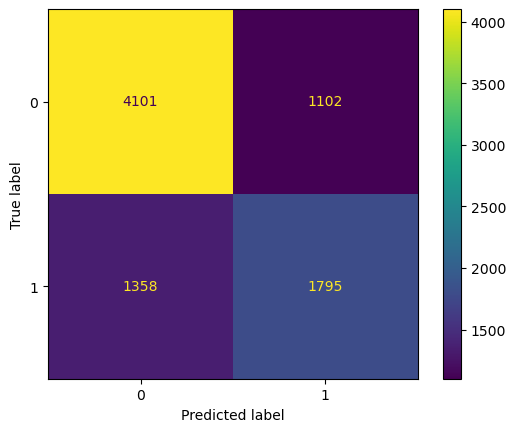

In [31]:
# Comprovamos los resultados en una matriz de confusion. 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

# 15 dias o menos

Repetimos el mismo proceso para el dataset con reservas con 15 dias o menos de antelacion. 

In [32]:
# Añadimos los datos meteorologicos al dataset. 
meteo_algarve.rename(columns={'datetime': 'arrival_date'},inplace=True)
meteo_lisboa.rename(columns={'datetime': 'arrival_date'},inplace=True)
meteo_complete = pd.merge(meteo_algarve,meteo_lisboa, how="outer")
meteo_complete["arrival_date"] = pd.to_datetime(meteo_complete["arrival_date"])
poca_antelacion_meteo = pd.merge(poca_antelacion, meteo_complete, on=['hotel','arrival_date'], how='left')

In [33]:
poca_antelacion_meteo = pd.get_dummies(poca_antelacion_meteo)
poca_antelacion_meteo.iloc[0], poca_antelacion_meteo.shape

(is_canceled                                            0
 stays_in_weekend_nights                                0
 stays_in_week_nights                                   1
 adults                                                 1
 children                                               0
 babies                                                 0
 is_repeated_guest                                      0
 previous_cancellations                                 0
 previous_bookings_not_canceled                         0
 booking_changes                                        0
 days_in_waiting_list                                   0
 total_of_special_requests                              0
 reservation_status_date              2015-07-02 00:00:00
 arrival_date                         2015-07-01 00:00:00
 tempmax                                            24.80
 tempmin                                            17.20
 temp                                               21.20
 precip       

In [34]:
# Partimos de las features que hemos escogido para el modelo de más de 15 dias. 
# Igual que antes, elegimos n-1 categiorias en cada variable categorica. 
# Tambien hemos eliminado lead_time por el motivo explicado al principio del notebook. 
features = [
    "stays_in_week_nights",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_BB",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Contract",
    "customer_type_Transient",
    "tempmax",
    "tempmin",
    "temp",
    "precip",
    "precipprob",
    "windgust",
    "windspeed",
    "cloudcover",
    "conditions_Clear",
    "conditions_Overcast",
    "conditions_Partially cloudy",
    "conditions_Rain",
    "conditions_Rain, Overcast"
]

In [35]:
X = poca_antelacion_meteo[features]
y = poca_antelacion_meteo['is_canceled']
train_data = poca_antelacion_meteo[(poca_antelacion_meteo['arrival_date'] >= pd.Timestamp('2015-07-01')) & 
                              (poca_antelacion_meteo['arrival_date'] <= pd.Timestamp('2017-06-30'))]
test_data = poca_antelacion_meteo[(poca_antelacion_meteo['arrival_date'] >= pd.Timestamp('2017-07-01')) & 
                             (poca_antelacion_meteo['arrival_date'] <= pd.Timestamp('2017-08-31'))]
# Balancear los datos
#Contar la frecuencia de cada clase y obtener la frecuencia mínima entre las clases
frecuencia_minima = train_data['is_canceled'].value_counts().min()

#Crear una muestra ponderada según la frecuencia de la clase minoritaria
train_data = train_data.groupby('is_canceled').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)

X_train = train_data[features]
y_train = train_data['is_canceled']
X_test = test_data[features]
y_test = test_data['is_canceled']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(19208, 35) (19208,) (1882, 35) (1882,)


In [36]:
# Escalar los datos

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [37]:
df_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
df_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

In [38]:
model = xgb.XGBClassifier()
model.fit(X_train_sc, y_train)
feature_importances = model.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))
for feature, importance in sorted_feature_importance.items():
    print(f'Feature: {feature}, Importance: {importance}')

Feature: deposit_type_Non Refund, Importance: 0.14213870465755463
Feature: market_segment_Groups, Importance: 0.13655494153499603
Feature: previous_cancellations, Importance: 0.09401993453502655
Feature: hotel_City Hotel, Importance: 0.07557165622711182
Feature: previous_bookings_not_canceled, Importance: 0.05748375877737999
Feature: market_segment_TA/TO, Importance: 0.052311621606349945
Feature: country_PRT, Importance: 0.05147284269332886
Feature: customer_type_Transient, Importance: 0.03703044354915619
Feature: meal_HB, Importance: 0.026402555406093597
Feature: stays_in_week_nights, Importance: 0.02527814358472824
Feature: customer_type_Contract, Importance: 0.02329300530254841
Feature: booking_changes, Importance: 0.021804573014378548
Feature: market_segment_Direct, Importance: 0.021290134638547897
Feature: days_in_waiting_list, Importance: 0.019040945917367935
Feature: market_segment_Corporate, Importance: 0.015374679118394852
Feature: total_of_special_requests, Importance: 0.0152

In [39]:
df = df_train_sc[features]
df['is_canceled'] = y_train
corr = df.corr()

In [40]:
corr[corr.is_canceled.abs()<0.02].index

Index(['customer_type_Contract', 'precip', 'precipprob', 'windspeed',
       'cloudcover', 'conditions_Overcast', 'conditions_Rain',
       'conditions_Rain, Overcast'],
      dtype='object')

In [41]:
features_2 = [
    "stays_in_week_nights",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_BB",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Transient",
    "tempmax",
    "tempmin",
    "temp",
    "windgust",
    "conditions_Partially cloudy"
]

In [42]:
df = df_train_sc[features_2]
df['is_canceled'] = y_train
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,stays_in_week_nights,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,total_of_special_requests,hotel_City Hotel,meal_BB,meal_FB,meal_HB,country_DEU,country_ESP,country_FRA,country_GBR,country_PRT,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_TA/TO,deposit_type_Non Refund,customer_type_Transient,tempmax,tempmin,temp,windgust,conditions_Partially cloudy,is_canceled
stays_in_week_nights,1.000,-0.011,-0.046,0.118,0.006,0.052,0.020,-0.037,0.020,0.042,0.016,-0.030,0.024,0.049,-0.134,-0.091,-0.048,-0.025,0.116,-0.024,0.042,-0.020,-0.005,-0.015,0.008,-0.007,0.181
previous_cancellations,-0.011,1.000,0.462,-0.016,-0.011,0.000,0.054,0.025,-0.001,0.006,-0.019,-0.041,-0.024,-0.026,0.120,0.106,-0.035,0.035,-0.068,0.064,-0.032,-0.006,0.010,-0.001,0.034,0.022,0.057
previous_bookings_not_canceled,-0.046,0.462,1.000,0.014,-0.009,0.037,0.002,0.059,-0.009,-0.034,-0.022,-0.033,-0.027,-0.029,0.110,0.283,-0.027,-0.043,-0.140,-0.018,0.045,-0.027,-0.036,-0.032,-0.016,-0.002,-0.098
booking_changes,0.118,-0.016,0.014,1.000,-0.010,0.006,-0.029,-0.019,0.004,0.031,-0.001,-0.005,-0.011,-0.004,-0.008,0.031,0.091,0.000,-0.095,-0.045,-0.026,-0.029,-0.028,-0.029,-0.021,-0.010,-0.082
days_in_waiting_list,0.006,-0.011,-0.009,-0.010,1.000,-0.049,0.045,-0.013,-0.006,0.055,-0.013,-0.022,-0.019,-0.017,0.066,-0.020,-0.032,0.069,-0.003,0.049,-0.107,-0.005,-0.003,-0.006,0.022,0.033,0.071
total_of_special_requests,0.052,0.000,0.037,0.006,-0.049,1.000,0.007,0.005,-0.040,-0.039,0.011,0.065,0.061,0.055,-0.151,-0.125,-0.067,-0.213,0.246,-0.118,0.149,0.052,0.060,0.056,-0.055,0.007,-0.095
hotel_City Hotel,0.020,0.054,0.002,-0.029,0.045,0.007,1.000,-0.096,-0.095,-0.085,0.067,-0.074,0.117,-0.046,-0.179,-0.069,-0.154,-0.012,0.152,0.055,-0.052,0.063,-0.013,-0.015,0.166,0.036,0.191
meal_BB,-0.037,0.025,0.059,-0.019,-0.013,0.005,-0.096,1.000,-0.154,-0.559,-0.028,-0.046,-0.025,-0.029,0.144,0.134,0.121,-0.056,-0.153,-0.010,0.020,-0.003,-0.002,0.001,-0.024,-0.023,-0.082
meal_FB,0.020,-0.001,-0.009,0.004,-0.006,-0.040,-0.095,-0.154,1.000,-0.022,-0.014,-0.007,-0.016,-0.016,0.059,-0.010,-0.012,0.130,-0.068,0.001,-0.091,-0.028,-0.006,-0.014,0.026,0.045,0.043
meal_HB,0.042,0.006,-0.034,0.031,0.055,-0.039,-0.085,-0.559,-0.022,1.000,-0.001,0.051,-0.030,0.000,0.022,-0.073,-0.048,0.101,0.025,0.093,-0.118,0.049,0.066,0.062,0.034,0.041,0.076


In [43]:
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=df.columns)
vif

stays_in_week_nights                 1.56
previous_cancellations               2.75
previous_bookings_not_canceled       3.53
booking_changes                      1.21
days_in_waiting_list                 1.12
total_of_special_requests            1.74
hotel_City Hotel                    57.05
meal_BB                              6.02
meal_FB                              1.56
meal_HB                              5.50
country_DEU                          1.56
country_ESP                          2.93
country_FRA                          2.31
country_GBR                          2.14
country_PRT                          9.84
market_segment_Corporate           150.64
market_segment_Direct              282.17
market_segment_Groups              222.15
market_segment_TA/TO               631.09
deposit_type_Non Refund              2.40
customer_type_Transient              4.73
tempmax                          19992.32
tempmin                          13517.95
temp                             6

In [44]:
df_2 = df.drop(columns=["tempmax",
                        "tempmin"])
corr = df_2.corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=df_2.columns)
vif

stays_in_week_nights               1.52
previous_cancellations             2.70
previous_bookings_not_canceled     3.49
booking_changes                    1.20
days_in_waiting_list               1.12
total_of_special_requests          1.72
hotel_City Hotel                   2.97
meal_BB                            6.02
meal_FB                            1.55
meal_HB                            5.48
country_DEU                        1.56
country_ESP                        2.89
country_FRA                        2.30
country_GBR                        2.12
country_PRT                        9.80
market_segment_Corporate         150.46
market_segment_Direct            282.06
market_segment_Groups            221.64
market_segment_TA/TO             630.65
deposit_type_Non Refund            2.30
customer_type_Transient            4.66
temp                               1.16
windgust                           1.30
conditions_Partially cloudy        1.15
is_canceled                        2.68


In [45]:
# Temperatura máxima y mínima están altamente correlacionadas con la temperatura.
features_3 = [
    "stays_in_week_nights",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_BB",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Transient",
    "temp",
    "windgust",
    "conditions_Partially cloudy"
]

In [46]:
X_train_sc = df_train_sc[features_3]
y_train = train_data['is_canceled']
X_test_sc = df_test_sc[features_3]
y_test = test_data['is_canceled']
log_reg = sm.Logit(y_train, X_train_sc).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.565021
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                19208
Model:                          Logit   Df Residuals:                    19184
Method:                           MLE   Df Model:                           23
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.1848
Time:                        17:12:03   Log-Likelihood:                -10853.
converged:                       True   LL-Null:                       -13314.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
stays_in_week_nights               0.5299      0.021     25.558     

In [47]:
# Las dos feautres con alto P-value son precip y conditions_Partially cloudy. De momento seguiremos sin eliminar precip. 
features_4 = [
    "stays_in_week_nights",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_PRT",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Transient",
    "temp",
    "conditions_Partially cloudy"
]

In [48]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X_train_sc = df_train_sc[features_4]
y_train = train_data['is_canceled']
X_test_sc = df_test_sc[features_4]
y_test = test_data['is_canceled']

# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)

In [49]:
# Entrenamiento modelo con precipitacion


model = xgb.XGBClassifier()
model.fit(X_train_sc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
y_pred = model.predict(X_test_sc)

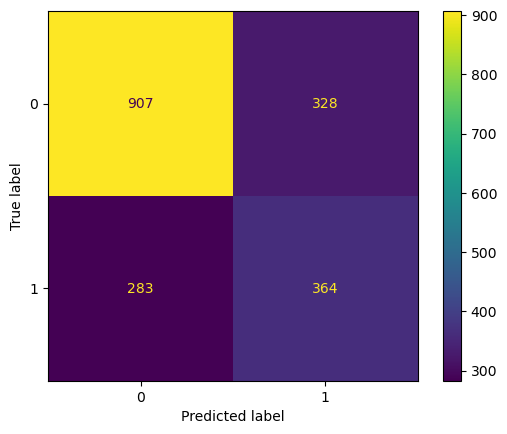

In [51]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [52]:
# Ahora provamos lo mismo sin las dos unicas variables de meteorologia que nos han sobrevivido
features_4 = [
    "stays_in_week_nights",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_PRT",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Transient"
]

In [53]:
X_train_sc = df_train_sc[features_4]
y_train = train_data['is_canceled']
X_test_sc = df_test_sc[features_4]
y_test = test_data['is_canceled']

model = xgb.XGBClassifier()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

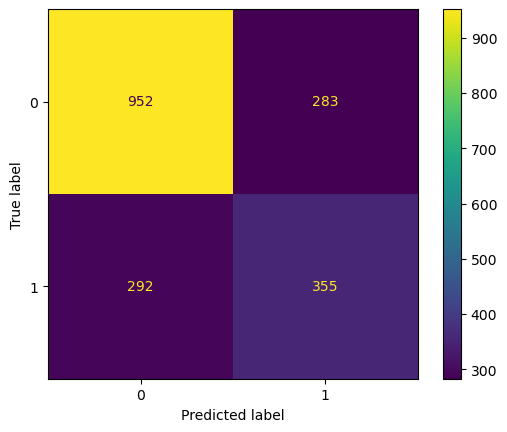

In [54]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

Viendo los resultados que estamos obteniendo, aunque sea sin optimizar los hiperparámetros, podemos concluir que las variables meteorológicas no mejoran el modelo de machine learning y no hace falta incluirlas. Por tanto, no es necesario separar el dataset. 

### Dataset entero

In [55]:
# Repetimos el mismo procedimiento de seleccion de features con el mismo criterio que anteriormente. 

In [56]:
reservas = pd.read_csv("Data/hotel_bookings_clean.csv")
reservas['arrival_date'] = pd.to_datetime(reservas['arrival_date'])
reservas['reservation_status_date'] = pd.to_datetime(reservas['reservation_status_date'])
reservas['children'] = reservas['children'].astype(int)

In [57]:
reservas['arrival_date_year'] = reservas['arrival_date'].dt.year
reservas['arrival_date_day/month'] = reservas['arrival_date'].dt.strftime('%d/%m')

In [58]:
dias_por_mes_1 = [
    31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31
]
dias_por_mes_2 = [
    31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31
]

def dia_del_año(dia_mes, anio): 
    dia, mes = dia_mes.split('/')
    dia = int(dia)
    mes = int(mes)
    if anio%4 == 0: 
        return dia + sum(dias_por_mes_2[:mes-1])
    else:
        return dia + sum(dias_por_mes_1[:mes-1])

dias_mes = list(reservas['arrival_date_day/month'])
anios = list(reservas['arrival_date_year'])

dias_x = []
dias_y = []
for dia, anio in zip(dias_mes,anios):
    if anio%4 == 0:
        angulo = 2*np.pi * dia_del_año(dia,anio)/366
        dias_x.append(np.cos(angulo))
        dias_y.append(np.sin(angulo))
    else:
        angulo = 2*np.pi * dia_del_año(dia,anio)/365
        dias_x.append(np.cos(angulo))
        dias_y.append(np.sin(angulo))
reservas['dia_x'] = dias_x
reservas['dia_y'] = dias_y
reservas.drop(columns=["arrival_date_day/month","arrival_date_year"],inplace=True) 

In [59]:
reservas = pd.get_dummies(reservas)
reservas.iloc[0], reservas.shape

(is_canceled                                         0
 lead_time                                         342
 stays_in_weekend_nights                             0
 stays_in_week_nights                                0
 adults                                              2
 children                                            0
 babies                                              0
 is_repeated_guest                                   0
 previous_cancellations                              0
 previous_bookings_not_canceled                      0
 booking_changes                                     3
 days_in_waiting_list                                0
 total_of_special_requests                           0
 reservation_status_date           2015-07-01 00:00:00
 arrival_date                      2015-07-01 00:00:00
 dia_x                                           -1.00
 dia_y                                            0.01
 hotel_City Hotel                                    0
 hotel_Res

In [60]:
features = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "dia_x",
    "dia_y",
    "hotel_City Hotel",
    "meal_BB",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Aviation",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "distribution_channel_Corporate",
    "distribution_channel_Direct",
    "distribution_channel_TA/TO",
    "deposit_type_Non Refund",
    "deposit_type_Refundable",
    "customer_type_Contract",
    "customer_type_Group",
    "customer_type_Transient"
]

In [61]:
X = reservas[features]
y = reservas['is_canceled']
train_data = reservas[(reservas['arrival_date'] >= pd.Timestamp('2015-07-01')) & 
                              (reservas['arrival_date'] <= pd.Timestamp('2017-06-30'))]
test_data = reservas[(reservas['arrival_date'] >= pd.Timestamp('2017-07-01')) & 
                             (reservas['arrival_date'] <= pd.Timestamp('2017-08-31'))]

# Balancear los datos
#Contar la frecuencia de cada clase y obtener la frecuencia mínima entre las clases
frecuencia_minima = train_data['is_canceled'].value_counts().min()

#Crear una muestra ponderada según la frecuencia de la clase minoritaria
train_data = train_data.groupby('is_canceled').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)

X_train = train_data[features]
y_train = train_data['is_canceled']
X_test = test_data[features]
y_test = test_data['is_canceled']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(80706, 36) (80706,) (10238, 36) (10238,)


In [62]:
# Escalar los datos

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [63]:
X_train_sc

array([[-0.32826325, -0.91386915,  0.80990318, ..., -0.1895103 ,
        -0.06427044,  0.57049197],
       [ 2.24547836,  1.0962619 ,  1.34082612, ..., -0.1895103 ,
        -0.06427044,  0.57049197],
       [-0.47481082, -0.91386915,  0.27898025, ..., -0.1895103 ,
        -0.06427044,  0.57049197],
       ...,
       [-0.4290147 , -0.91386915, -0.78286562, ..., -0.1895103 ,
        -0.06427044,  0.57049197],
       [-0.47481082, -0.91386915, -0.25194269, ..., -0.1895103 ,
        -0.06427044,  0.57049197],
       [ 0.02894644, -0.91386915, -0.25194269, ..., -0.1895103 ,
        -0.06427044, -1.75287306]])

In [64]:
df_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
df_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

In [65]:
model = xgb.XGBClassifier()
model.fit(X_train_sc, y_train)
feature_importances = model.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))
for feature, importance in sorted_feature_importance.items():
    print(f'Feature: {feature}, Importance: {importance}')

Feature: deposit_type_Non Refund, Importance: 0.6928089261054993
Feature: customer_type_Transient, Importance: 0.04264575242996216
Feature: previous_cancellations, Importance: 0.033171333372592926
Feature: country_PRT, Importance: 0.02970357984304428
Feature: market_segment_TA/TO, Importance: 0.017626143991947174
Feature: total_of_special_requests, Importance: 0.014117153361439705
Feature: country_FRA, Importance: 0.011287123896181583
Feature: previous_bookings_not_canceled, Importance: 0.011027167551219463
Feature: country_DEU, Importance: 0.009918305091559887
Feature: hotel_City Hotel, Importance: 0.009845072403550148
Feature: customer_type_Contract, Importance: 0.00900866836309433
Feature: lead_time, Importance: 0.008901236578822136
Feature: distribution_channel_Direct, Importance: 0.00870135985314846
Feature: booking_changes, Importance: 0.008647865615785122
Feature: country_GBR, Importance: 0.008272802457213402
Feature: market_segment_Groups, Importance: 0.007454475853592157
Featu

In [66]:
df = df_train_sc[features]
df['is_canceled'] = y_train
corr = df.corr()
corr[corr.is_canceled.abs()<0.02].index

Index(['stays_in_weekend_nights', 'children', 'dia_y', 'meal_BB',
       'market_segment_Aviation', 'deposit_type_Refundable'],
      dtype='object')

In [67]:
features_2 = [
    "lead_time",
    "adults",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "distribution_channel_Corporate",
    "distribution_channel_Direct",
    "distribution_channel_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Contract",
    "customer_type_Transient"
]

In [68]:
df = df_train_sc[features_2]
df['is_canceled'] = y_train
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,lead_time,adults,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,total_of_special_requests,hotel_City Hotel,meal_FB,meal_HB,country_DEU,country_ESP,country_FRA,country_GBR,country_PRT,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_TA/TO,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_TA/TO,deposit_type_Non Refund,customer_type_Contract,customer_type_Transient,is_canceled
lead_time,1.000,0.111,-0.026,-0.109,0.105,-0.066,-0.028,0.182,-0.144,0.079,0.010,0.104,0.028,-0.136,-0.076,0.036,0.172,-0.158,-0.178,0.392,-0.144,-0.131,-0.164,0.221,0.436,0.082,-0.144,0.313
adults,0.111,1.000,0.015,-0.124,0.000,-0.091,-0.047,-0.007,0.101,-0.021,0.010,0.050,0.012,0.037,0.045,0.029,-0.105,-0.203,0.015,-0.033,0.116,-0.194,-0.003,0.126,-0.033,0.020,0.073,0.059
babies,-0.026,0.015,1.000,-0.008,-0.008,-0.006,0.087,-0.011,0.099,-0.043,0.013,0.015,-0.010,0.026,-0.001,0.005,-0.004,-0.007,0.055,-0.037,-0.001,-0.008,0.051,-0.038,-0.036,-0.000,0.021,-0.034
is_repeated_guest,-0.109,-0.124,-0.008,1.000,0.072,0.411,0.011,-0.023,0.015,-0.047,-0.012,-0.038,-0.035,-0.031,-0.039,-0.038,0.136,0.273,0.062,-0.038,-0.145,0.256,0.067,-0.213,-0.068,-0.024,0.002,-0.092
previous_cancellations,0.105,0.000,-0.008,0.072,1.000,0.124,-0.030,0.004,-0.055,-0.023,0.163,0.023,-0.027,-0.029,-0.034,-0.033,0.101,0.009,-0.030,0.105,-0.075,0.053,-0.031,-0.006,0.137,0.039,-0.037,0.105
previous_bookings_not_canceled,-0.066,-0.091,-0.006,0.411,0.124,1.000,0.014,-0.008,0.039,-0.002,-0.006,-0.026,-0.018,-0.019,-0.020,-0.022,0.077,0.252,0.001,-0.035,-0.095,0.234,0.015,-0.155,-0.037,-0.015,0.022,-0.064
booking_changes,-0.028,-0.047,0.087,0.011,-0.030,0.014,1.000,-0.015,0.061,-0.081,-0.001,0.042,0.007,0.019,0.005,0.039,-0.089,0.036,0.090,-0.028,-0.048,0.062,0.099,-0.120,-0.135,-0.026,-0.084,-0.159
days_in_waiting_list,0.182,-0.007,-0.011,-0.023,0.004,-0.008,-0.015,1.000,-0.085,0.081,-0.013,0.030,-0.009,-0.032,-0.005,-0.038,0.094,-0.029,-0.045,0.087,-0.032,-0.032,-0.041,0.055,0.126,-0.028,-0.083,0.054
total_of_special_requests,-0.144,0.101,0.099,0.015,-0.055,0.039,0.061,-0.085,1.000,-0.059,-0.040,-0.029,0.037,0.057,0.075,0.059,-0.240,-0.081,0.015,-0.292,0.268,-0.099,-0.006,0.067,-0.302,0.048,0.122,-0.254
hotel_City Hotel,0.079,-0.021,-0.043,-0.047,-0.023,-0.002,-0.081,0.081,-0.059,1.000,-0.119,-0.177,0.072,-0.068,0.102,-0.168,-0.029,-0.042,-0.135,0.044,0.058,-0.084,-0.171,0.192,0.197,-0.014,-0.000,0.157


In [69]:
df = df_train_sc[features_2]
df['is_canceled'] = y_train
corr = df.corr()
# vif_data = pd.DataFrame()
# vif_data["Variable"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=df.columns)
vif

lead_time                            5.41
adults                               2.27
babies                               1.11
is_repeated_guest                    4.27
previous_cancellations               1.44
previous_bookings_not_canceled       2.66
booking_changes                      1.37
days_in_waiting_list                 1.31
total_of_special_requests            2.88
hotel_City Hotel                     4.47
meal_FB                              1.35
meal_HB                              1.58
country_DEU                          2.03
country_ESP                          2.46
country_FRA                          2.47
country_GBR                          3.14
country_PRT                         15.63
market_segment_Corporate           804.94
market_segment_Direct             1875.51
market_segment_Groups             4776.58
market_segment_TA/TO              8218.59
distribution_channel_Corporate   16259.69
distribution_channel_Direct      38924.54
distribution_channel_TA/TO       5

In [70]:
df_2 = df.drop(columns=["distribution_channel_Corporate",
                        "distribution_channel_Direct",
                        "distribution_channel_TA/TO"])
corr = df_2.corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=df_2.columns)
vif

lead_time                           5.37
adults                              1.68
babies                              1.10
is_repeated_guest                   3.82
previous_cancellations              1.39
previous_bookings_not_canceled      2.57
booking_changes                     1.31
days_in_waiting_list                1.31
total_of_special_requests           2.60
hotel_City Hotel                    2.71
meal_FB                             1.31
meal_HB                             1.54
country_DEU                         2.02
country_ESP                         2.33
country_FRA                         2.42
country_GBR                         3.03
country_PRT                        14.98
market_segment_Corporate          471.91
market_segment_Direct            1013.28
market_segment_Groups            3634.35
market_segment_TA/TO             4595.67
deposit_type_Non Refund            19.68
customer_type_Contract              2.18
customer_type_Transient             7.45
is_canceled     

In [71]:
features_3 = [
    "lead_time",
    "adults",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_ESP",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Direct",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Contract",
    "customer_type_Transient"
]

In [72]:
X_train_sc = df_train_sc[features_3]
y_train = train_data['is_canceled']
X_test_sc = df_test_sc[features_3]
y_test = test_data['is_canceled']
log_reg = sm.Logit(y_train, X_train_sc).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.467199
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                80706
Model:                          Logit   Df Residuals:                    80682
Method:                           MLE   Df Model:                           23
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.3260
Time:                        17:12:06   Log-Likelihood:                -37706.
converged:                       True   LL-Null:                       -55941.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
lead_time                          0.5680      0.013     45.189     

In [73]:
features_4 = [
    "lead_time",
    "adults",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "hotel_City Hotel",
    "meal_FB",
    "meal_HB",
    "country_DEU",
    "country_FRA",
    "country_GBR",
    "country_PRT",
    "market_segment_Corporate",
    "market_segment_Groups",
    "market_segment_TA/TO",
    "deposit_type_Non Refund",
    "customer_type_Transient"
]

In [74]:
X_train_sc = df_train_sc[features_4]
y_train = train_data['is_canceled']
X_test_sc = df_test_sc[features_4]
y_test = test_data['is_canceled']

model = xgb.XGBClassifier()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

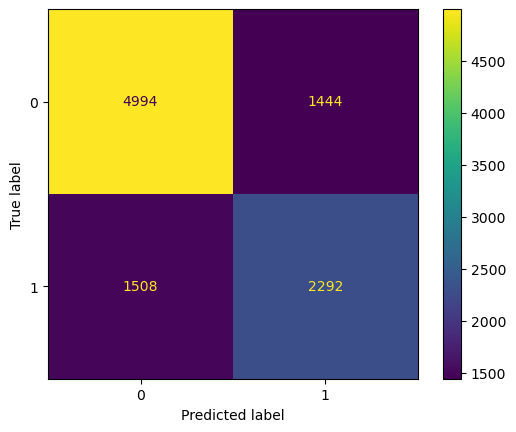

In [75]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      6438
           1       0.61      0.60      0.61      3800

    accuracy                           0.71     10238
   macro avg       0.69      0.69      0.69     10238
weighted avg       0.71      0.71      0.71     10238



In [77]:
y_pred_train = model.predict(X_train_sc)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83     40353
           1       0.85      0.78      0.82     40353

    accuracy                           0.82     80706
   macro avg       0.83      0.82      0.82     80706
weighted avg       0.83      0.82      0.82     80706



In [78]:
# PCA

from sklearn.decomposition import PCA
pca = PCA(.99)
pca.fit(X_train_sc)
X_pca_train = pca.transform(X_train_sc)
X_pca_test = pca.transform(X_test_sc)

In [79]:
len(features_4)

20

In [80]:
print(pca.explained_variance_ratio_)

[0.14973281 0.09807957 0.07482453 0.06378491 0.05854288 0.05602414
 0.05342439 0.05126349 0.04822794 0.04709578 0.04387637 0.04169778
 0.03895443 0.03616731 0.03429244 0.03098648 0.0287166  0.02130086
 0.01507717]


In [81]:
len(pca.explained_variance_ratio_)

19

In [82]:
model = xgb.XGBClassifier()
model.fit(X_pca_train, y_train)
y_pred = model.predict(X_pca_test)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      6438
           1       0.60      0.58      0.59      3800

    accuracy                           0.70     10238
   macro avg       0.68      0.67      0.68     10238
weighted avg       0.70      0.70      0.70     10238



In [84]:
y_pred_train = model.predict(X_pca_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85     40353
           1       0.87      0.80      0.83     40353

    accuracy                           0.84     80706
   macro avg       0.84      0.84      0.84     80706
weighted avg       0.84      0.84      0.84     80706



### Optimizacion de hiperparámetros

In [108]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

param_dist = {
    'learning_rate': stats.uniform(0.01,0.2),
    'max_depth': stats.randint(3, 10),
    'subsample': stats.uniform(0.5, 1),
    'colsample_bytree': stats.uniform(0.5,1),
    'colsample_bylevel': stats.uniform(0.5,1),
    'colsample_bynode': stats.uniform(0.5,1),
    'n_estimators':stats.randint(50, 200)
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=1000, cv=5, scoring='accuracy',verbose=1)
random_search.fit(X_train_sc, y_train)

print("Mejor conjunto de hiperparametros: ", random_search.best_params_)
print("Mejor accuracy: ", random_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Mejor conjunto de hiperparametros:  {'colsample_bylevel': 0.8091218301059356, 'colsample_bynode': 0.9221811441276574, 'colsample_bytree': 0.9355780801271562, 'learning_rate': 0.1503375535843294, 'max_depth': 8, 'n_estimators': 178, 'subsample': 0.7618354368056748}
Mejor accuracy:  0.8164696164916577


In [107]:
# Optimizacion Bayesiana (https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d)

from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.metrics import accuracy_score

In [109]:
# Acotamos los hiperparámetros en base a los resultados obtenidos en la RandomizedSearchCV
space = {
    'learning_rate': hp.loguniform('learning_rate', -1.3, -0.6), # Aplicamos logaritmo al maximo y al minimo para definir el rango
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'colsample_bytree': hp.quniform('colsample_bytree',0.8,1,0.05),
    'colsample_bylevel': hp.quniform('colsample_bylevel',0.6,1,0.05),
    'colsample_bynode': hp.quniform('colsample_bynode',0.8,1,0.05)
}
    
def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train_sc, y_train)
    y_pred = xgb_model.predict(X_test_sc)
    score = accuracy_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

best_params = fmin(objective, space, algo=tpe.suggest, max_evals=1000)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 1000/1000 [07:25<00:00,  2.24trial/s, best loss: -0.7182066809923813]
Best set of hyperparameters:  {'colsample_bylevel': 0.9500000000000001, 'colsample_bynode': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.28841810710611226, 'subsample': 0.8684439079467414}


In [122]:
from sklearn.ensemble import BaggingClassifier

In [123]:
# Creamos el clasificador base con los hiperparámetros:
best_params['max_depth'] = 8 
clasificador_base = xgb.XGBClassifier(**best_params)

In [127]:
# Creamos el clasificador Bagging
clasificador_bagging = BaggingClassifier(clasificador_base, n_estimators=178, random_state=42)

In [128]:
# Entrenamos
clasificador_bagging.fit(X_train_sc, y_train)

BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=0.9500000000000001,
                                          colsample_bynode=0.8,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.28841810710611226,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=8,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                  n_estimators=178, random_state=42)

In [130]:
y_pred = clasificador_bagging.predict(X_test_sc)

In [132]:
y_pred_train = clasificador_bagging.predict(X_train_sc)

In [136]:
print(f'accuracy en train:{accuracy_score(y_train,y_pred_train)}\naccuracy en test: {accuracy_score(y_test,y_pred)}')

accuracy en train:0.8385250167273809
accuracy en test: 0.7086344989255714


### Exportacion del modelo

In [137]:
from joblib import dump
dump(clasificador_bagging, 'modelo_proyecto.joblib') 

['modelo_proyecto.joblib']

### Entrenar el modelo con el dataset completo

In [151]:
reservas = pd.read_csv("Data/hotel_bookings_clean.csv")
reservas = pd.get_dummies(reservas)
X = reservas[features_4]
y = reservas['is_canceled']
frecuencia_minima = reservas['is_canceled'].value_counts().min()
reservas = reservas.groupby('is_canceled').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)

In [152]:
scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)

In [153]:
# Hiperparametros
param_dist = {
    'learning_rate': stats.uniform(0.01,0.2),
    'max_depth': stats.randint(3, 10),
    'subsample': stats.uniform(0.5, 1),
    'colsample_bytree': stats.uniform(0.5,1),
    'colsample_bylevel': stats.uniform(0.5,1),
    'colsample_bynode': stats.uniform(0.5,1),
    'n_estimators':stats.randint(50, 200)
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=1000, cv=5, scoring='accuracy',verbose=1)
random_search.fit(X_train_sc, y_train)

print("Mejor conjunto de hiperparametros: ", random_search.best_params_)
print("Mejor accuracy: ", random_search.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Mejor conjunto de hiperparametros:  {'colsample_bylevel': 0.6802712770473117, 'colsample_bynode': 0.9277478639798314, 'colsample_bytree': 0.864767956127546, 'learning_rate': 0.20462620315935748, 'max_depth': 9, 'n_estimators': 147, 'subsample': 0.8550046971419236}
Mejor accuracy:  0.8179689101612141


In [154]:
space = {
    'learning_rate': hp.loguniform('learning_rate', -1.3, -0.7), # Aplicamos logaritmo al maximo y al minimo para definir el rango
    'subsample': hp.uniform('subsample', 0.7, 0.95),
    'colsample_bytree': hp.quniform('colsample_bytree',0.7,1,0.05),
    'colsample_bylevel': hp.quniform('colsample_bylevel',0.5,0.9,0.05),
    'colsample_bynode': hp.quniform('colsample_bynode',0.8,1,0.05)
}
    
def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train_sc, y_train)
    y_pred = xgb_model.predict(X_test_sc)
    score = accuracy_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

best_params = fmin(objective, space, algo=tpe.suggest, max_evals=1000)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 1000/1000 [07:19<00:00,  2.28trial/s, best loss: -0.7195741355733541]
Best set of hyperparameters:  {'colsample_bylevel': 0.65, 'colsample_bynode': 0.8500000000000001, 'colsample_bytree': 0.75, 'learning_rate': 0.2725984287425052, 'subsample': 0.8892444859148654}


In [155]:
best_params['max_depth'] = 9
clasificador_base = xgb.XGBClassifier(**best_params)
clasificador_bagging = BaggingClassifier(clasificador_base, n_estimators=147, random_state=42)

In [156]:
clasificador_bagging.fit(X_sc, y)

BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=0.65,
                                          colsample_bynode=0.8500000000000001,
                                          colsample_bytree=0.75, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.2725984287425052,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=9,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                  n_estimators=147, random_state=42)

In [157]:
dump(clasificador_bagging, 'modelo_proyecto_entero.joblib') 

['modelo_proyecto_entero.joblib']